In [1]:
import pandas as pd
import numpy as np
import datetime

In [56]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'coolwarm'
%matplotlib inline

In [3]:
data_list = (('egamma', ('egamma_calibration', 'photon_id', 'tp', 'egamma')),
             ('higgs', ('HSG1', 'HSG3')))

df = []
df_meeting = []              
              
for group, subgroups in data_list:
    contributions = pd.concat([pd.read_pickle(s + "_contributions.pkl") for s in subgroups])
    meeting = pd.concat([pd.read_pickle(s + '_meeting.pkl') for s in subgroups])
    joined = contributions.join(meeting, on='id_meeting', lsuffix='_contribution')
    meeting['group'] = group
    joined['group'] = group
    df.append(joined)
    df_meeting.append(meeting)
              
df = pd.concat(df)
df_meeting = pd.concat(df_meeting)              
              
df_meeting_grouped_by_mytitle = df_meeting.groupby('my_title')
df_grouped_by_group = df.groupby('group')

In [4]:
df.head()

,duration,id_meeting,speaker,title_contribution,contributions,date_meeting,my_title,title,group
id_contribution,,,,,,,,,
137181,20,137181,"KOLETSOU, Iro",Monte Carlo Calibration,6,2011-04-29,egamma_calibration,Egamma Calibration Meeting,egamma
137181,10,137181,"AHARROUCHE, mohamed",Introduction,6,2011-04-29,egamma_calibration,Egamma Calibration Meeting,egamma
137181,20,137181,"AHARROUCHE, mohamed",Forward update,6,2011-04-29,egamma_calibration,Egamma Calibration Meeting,egamma
137181,20,137181,"DASSOULAS, James",Z->ee calibration update,6,2011-04-29,egamma_calibration,Egamma Calibration Meeting,egamma
137181,10,137181,NO SPEAKER,AOB,6,2011-04-29,egamma_calibration,Egamma Calibration Meeting,egamma


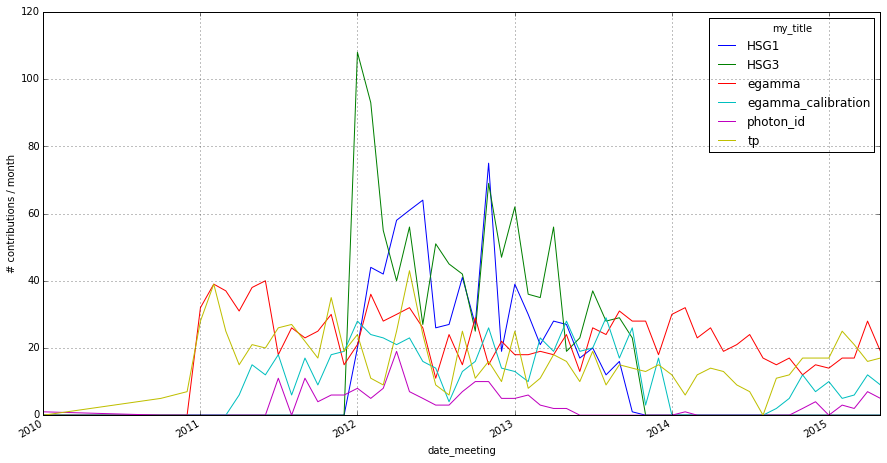

In [5]:
import matplotlib.dates as mdates
f, ax = plt.subplots(figsize=(15, 8))
df_meeting.groupby([pd.Grouper(freq='MS',key='date_meeting'), 'my_title'])['contributions'].sum().unstack().fillna(0).plot(ax=ax)
ax.set_ylabel('# contributions / month')

/usr/lib64/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


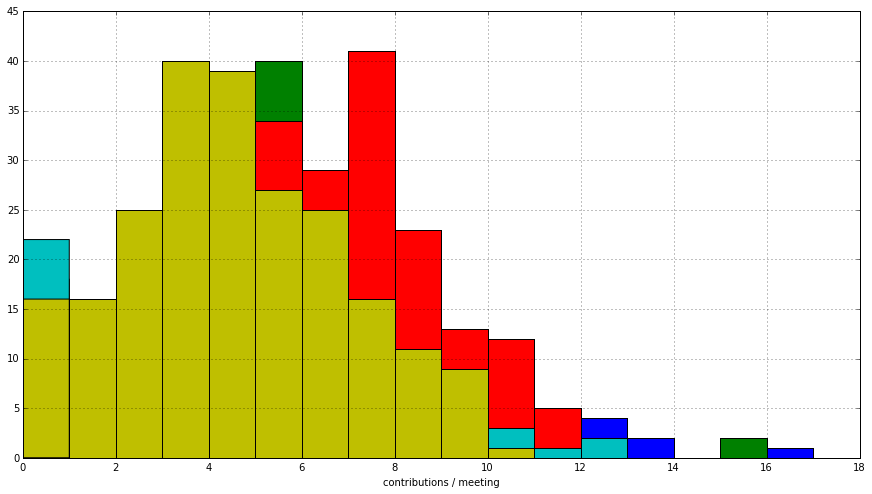

In [6]:
f, ax = plt.subplots(figsize=(15, 8))
df_meeting_grouped_by_mytitle['contributions'].hist(ax=ax, bins=np.arange(0, 18), alpha=0.5)
ax.set_xlabel('contributions / meeting')
ax.legend()

(733773.0, 735719.0)
(504.0, 525.0)


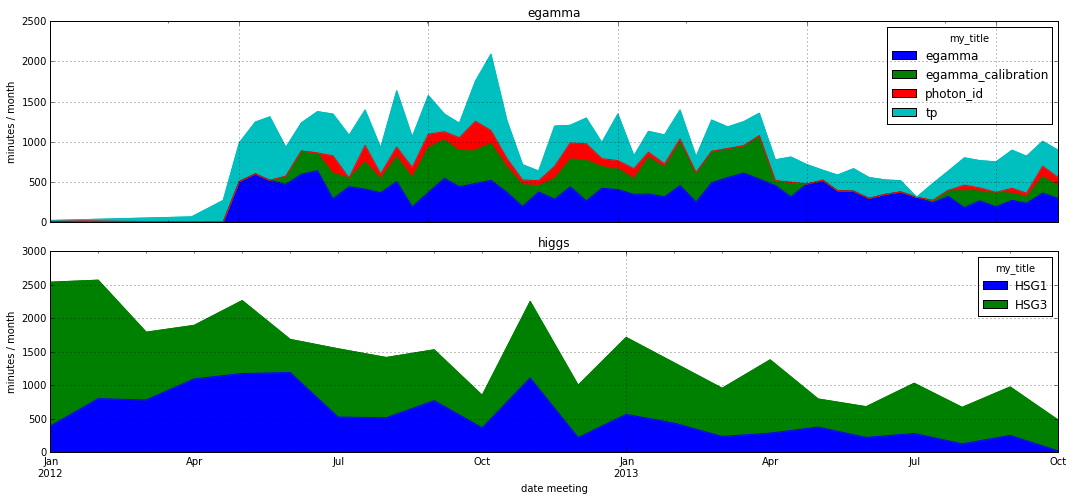

In [8]:
f, axs = plt.subplots(len(df_grouped_by_group), 1, figsize=(15, 7))
for ax, (group, df_group) in zip(axs.flat, df_grouped_by_group):
    df_group.groupby([pd.Grouper(freq='1MS',key='date_meeting'), 'my_title'])['duration'].sum().unstack().fillna(0).plot(kind='area', ax=ax)
    ax.set_ylabel('minutes / month')
    ax.set_xlabel('date meeting')
    ax.set_title(group)

min_x = np.min([ax.get_xlim()[0] for ax in axs.flat])
max_x = np.max([ax.get_xlim()[1] for ax in axs.flat])

for ax in axs.flat:
    print ax.get_xlim()
    #ax.set_xlim(min_x, max_x)

plt.tight_layout()
plt.show()    

/usr/lib64/python2.7/site-packages/pandas/core/frame.py:3176: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


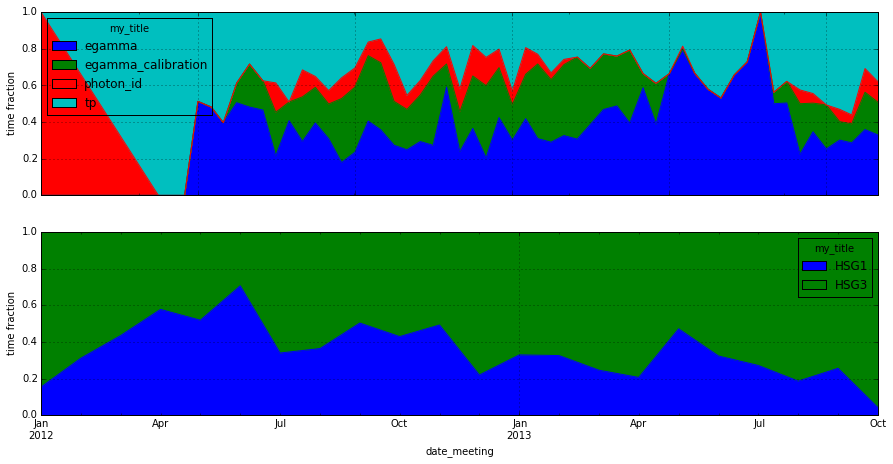

In [9]:
f, axs = plt.subplots(len(df_grouped_by_group), 1, figsize=(15, 8))
for ax, (group, df_group) in zip(axs.flat, df_grouped_by_group):
    (df_group.groupby([pd.Grouper(freq='1MS',key='date_meeting'), 'my_title'])['duration'].sum().unstack().fillna(0) / df_group.groupby([pd.Grouper(freq='1MS',key='date_meeting')])['duration'].sum()).plot(kind='area', ax=ax)
    ax.set_ylabel('time fraction')

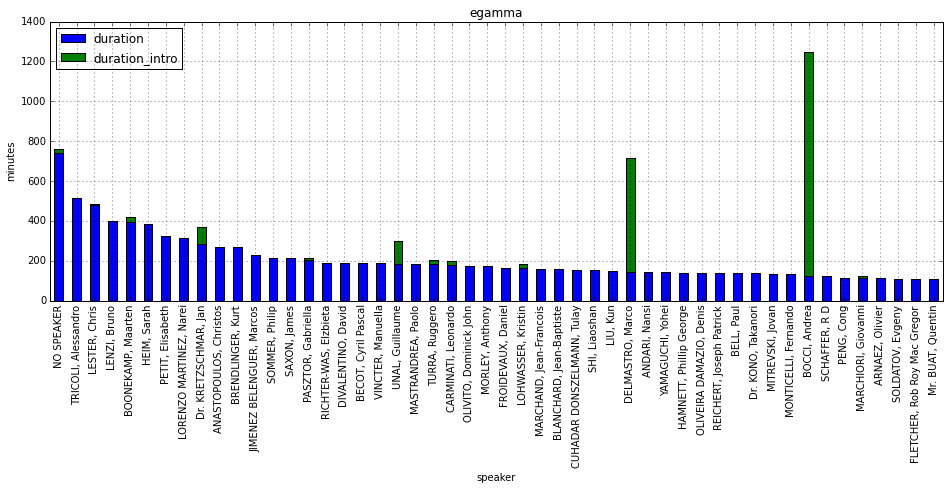

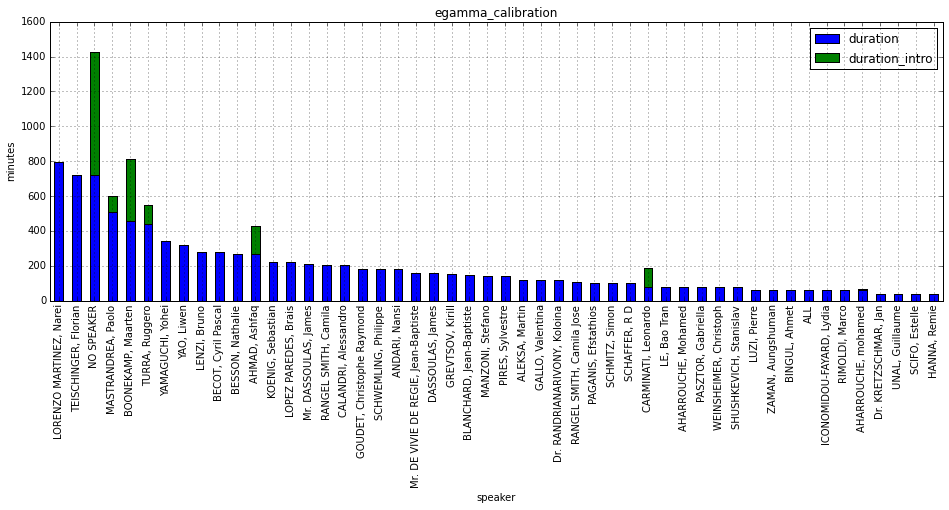

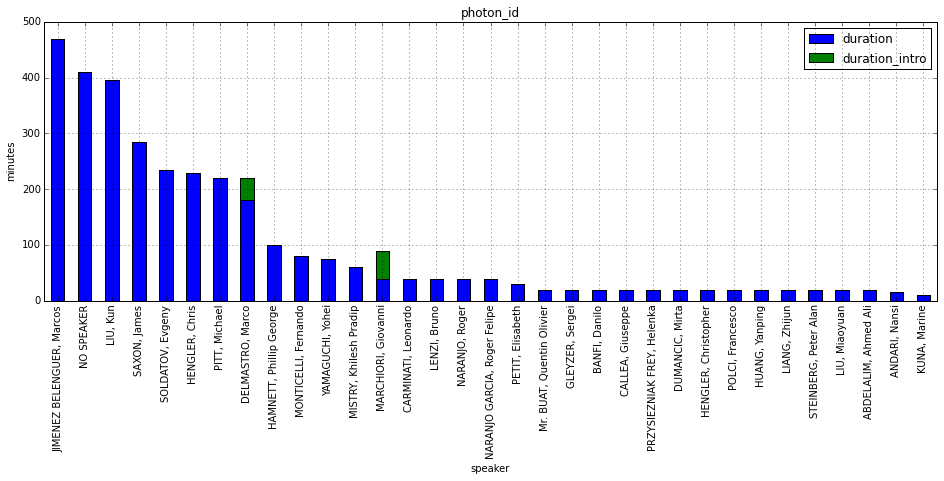

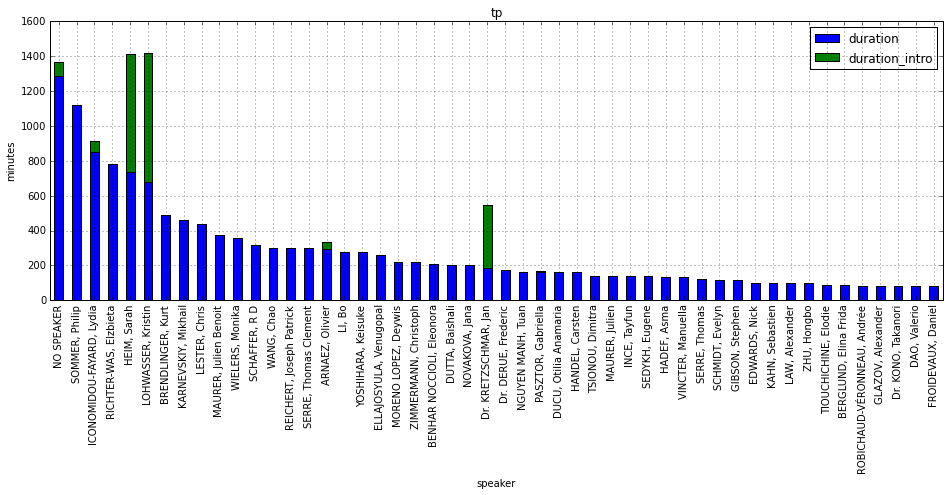

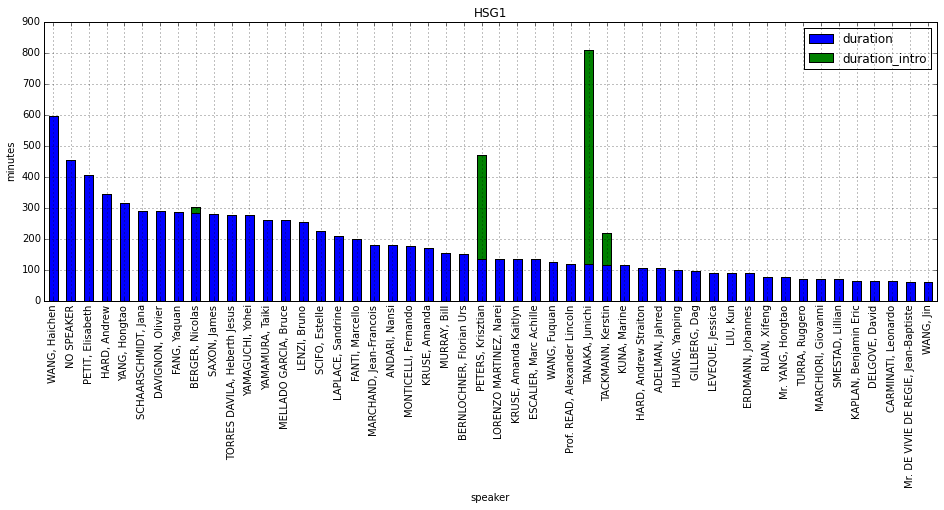

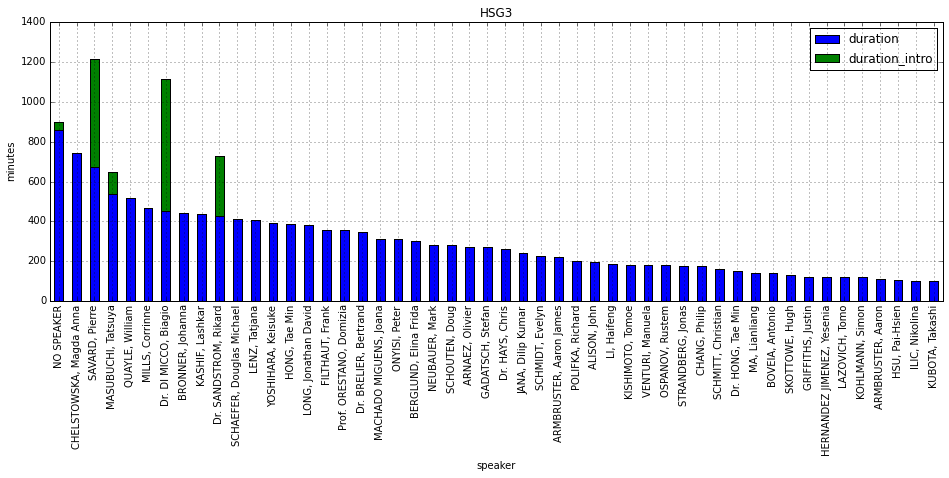

In [10]:
for group, df_group in df_grouped_by_group:
    g = df_group.groupby('my_title')['speaker', 'duration', 'title_contribution']
    for k, v in g:
        f, ax = plt.subplots(figsize=(16, 5))
        mask_introduction = v.apply(lambda x: 'introduction' in x['title_contribution'].lower(), axis=1)
        no_intro = v[np.logical_not(mask_introduction)].groupby('speaker')['duration'].sum().sort('duration', inplace=False, ascending=False)
        intro = v[mask_introduction].groupby('speaker')['duration'].sum()
        intro_values = [intro.get(name, 0) for name in no_intro.keys()]
        d = pd.DataFrame(no_intro)
        d['duration_intro'] = intro_values
        d[:50].plot(kind='bar', stacked=True, ax=ax)
        ax.set_ylabel('minutes')
        ax.set_title(k)


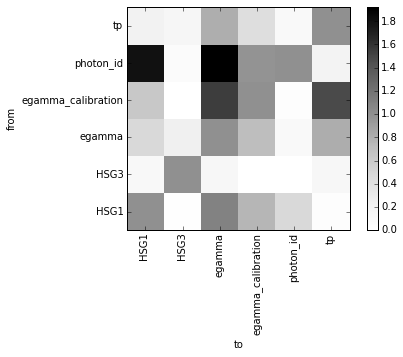

In [62]:
gr = df.groupby(['speaker', 'my_title'])['duration'].sum().unstack().fillna(0)
columns = gr.columns
result = np.zeros((len(columns), len(columns)))
for icol1, col1 in enumerate(columns):
    gr_col1 = gr[gr[col1] > 0]
    for icol2, col2 in enumerate(columns):
        m = np.mean(gr_col1[col2] / gr_col1[col1])
        result[icol1, icol2] = m

fig, ax = plt.subplots()
p = ax.pcolormesh(result, vmin=0, cmap='Greys')
ax.set_xticklabels(columns, rotation=90)
ax.set_yticklabels(columns)
ax.set_xticks(np.arange(len(columns)) + 0.5)
ax.set_yticks(np.arange(len(columns)) + 0.5)
ax.set_aspect('equal')
ax.set_ylabel('from')
ax.set_xlabel('to')
fig.colorbar(p)
plt.show()

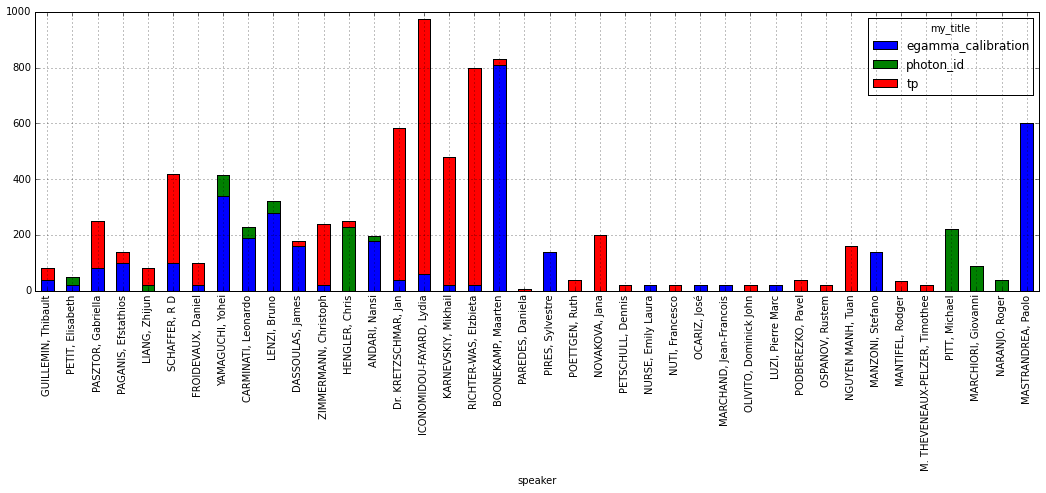

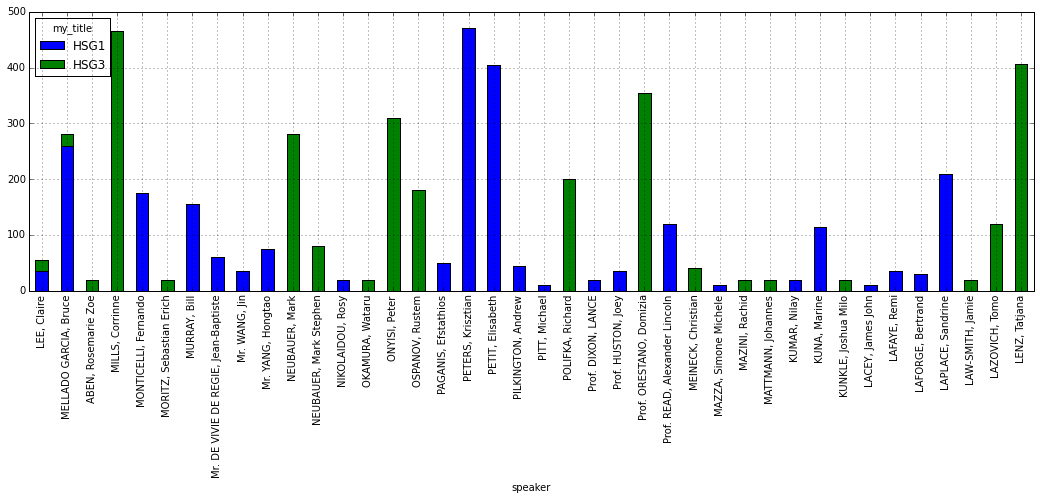

In [11]:
for group, group_data in df_grouped_by_group:
    speaker_summary = group_data.groupby(['speaker', 'my_title'])['duration'].sum().unstack().fillna(0)
    speaker_summary.drop('NO SPEAKER', inplace=True)
    speaker_summary.drop('ALL', inplace=True)
    if 'egamma' in speaker_summary.columns:
        speaker_summary.drop('egamma', axis=1, inplace=True)
    columns = speaker_summary.columns
    fraction_columns = ['fraction_' + c for c in columns]
    for column in columns:
        speaker_summary['fraction_' + column] = speaker_summary[column] / speaker_summary.sum(axis=1)
    speaker_summary['uniformity'] = speaker_summary[fraction_columns].std(axis=1)
    speaker_summary.sort('uniformity', ascending=True, inplace=True)
    speaker_summary
    to_plot = speaker_summary[columns][:40]

    to_plot.plot(kind='bar', stacked=True, figsize=(18, 5))

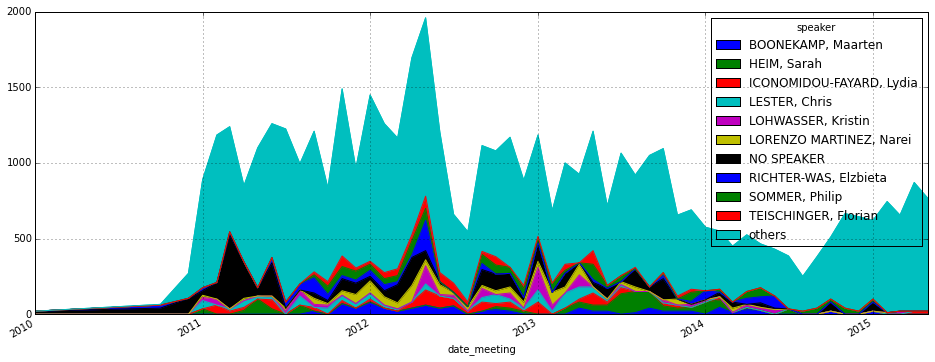

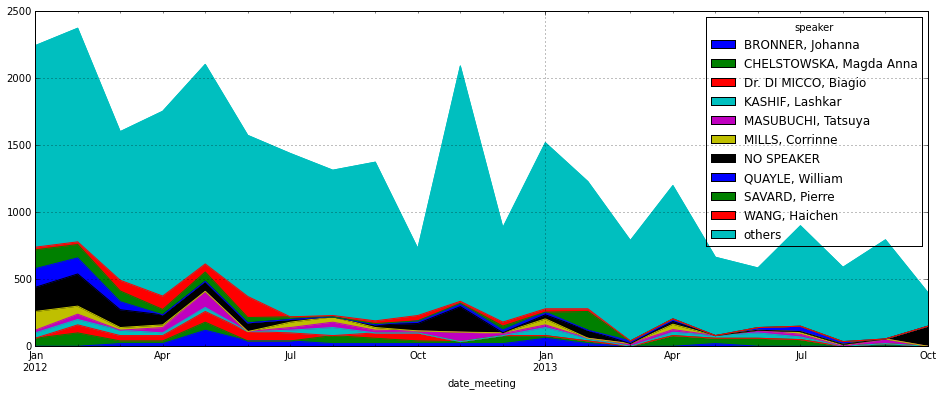

In [117]:
mask_introduction = df.apply(lambda x: 'introduction' in x['title_contribution'].lower(), axis=1)
df_no_introduction = df[np.logical_not(mask_introduction)]
df_grouped_by_group_no_introduction = df_no_introduction.groupby('group')
for group, group_data in df_grouped_by_group_no_introduction:
    g = group_data.groupby('speaker')['duration'].sum().sort(inplace=False, ascending=False)
    top_user = g[:10].keys()
    top_user_mask = [vv in top_user for vv in group_data['speaker']]
    g = group_data[top_user_mask].groupby([pd.Grouper(freq='MS',key='date_meeting'), 'speaker'])['duration'].sum().unstack()
    g_others = group_data[np.logical_not(top_user_mask)].groupby([pd.Grouper(freq='MS',key='date_meeting'), 'speaker'])['duration'].sum().unstack().sum(axis=1)
    g['others'] = g_others
    g.plot(kind='area', stacked=True, figsize=(16, 6))

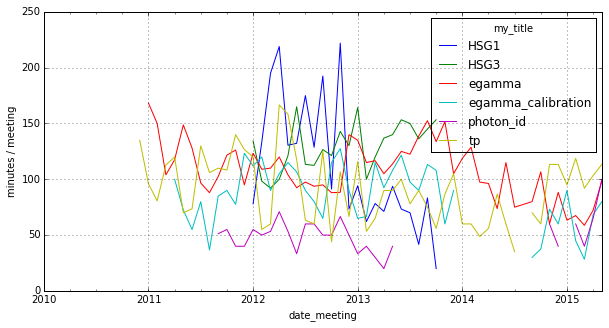

In [369]:
s =df.groupby(['date_meeting', 'my_title'])["duration"].sum().unstack()
s['date_meeting'] = s.index
ax = s.groupby(pd.Grouper(freq='1MS',key='date_meeting')).mean().plot(figsize=(10, 5))
ax.set_ylabel('minutes / meeting')

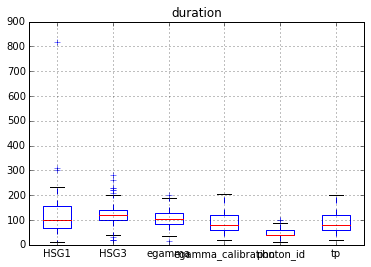

In [375]:
ax = df.groupby(['date_meeting', 'my_title'])["duration"].sum().unstack('my_title').plot(kind='box')
ax.set_title('duration')

In [377]:
words = df['title'].apply(lambda x: x.lower()).apply(lambda x: x.split()).sum()

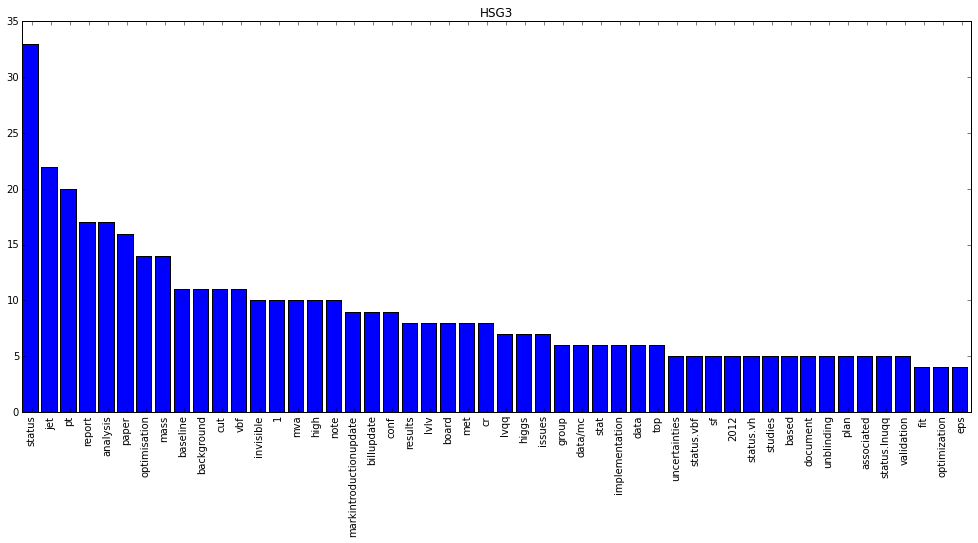

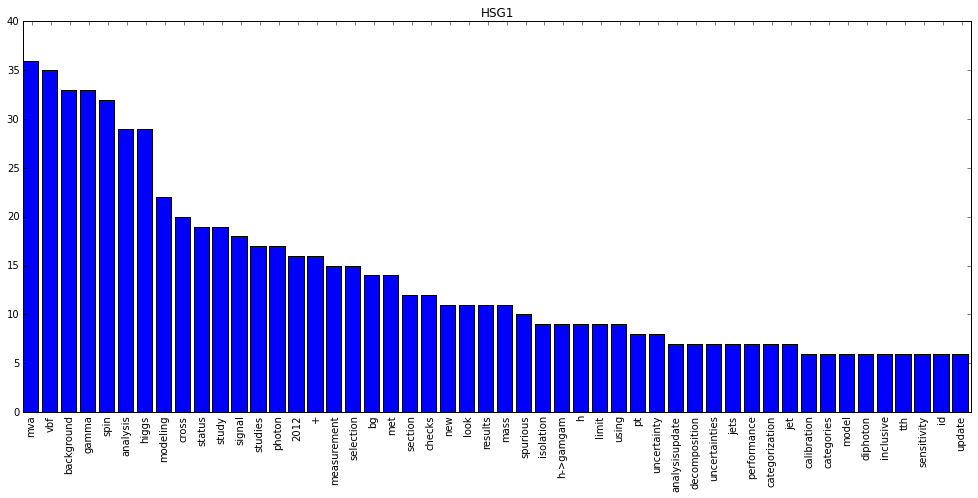

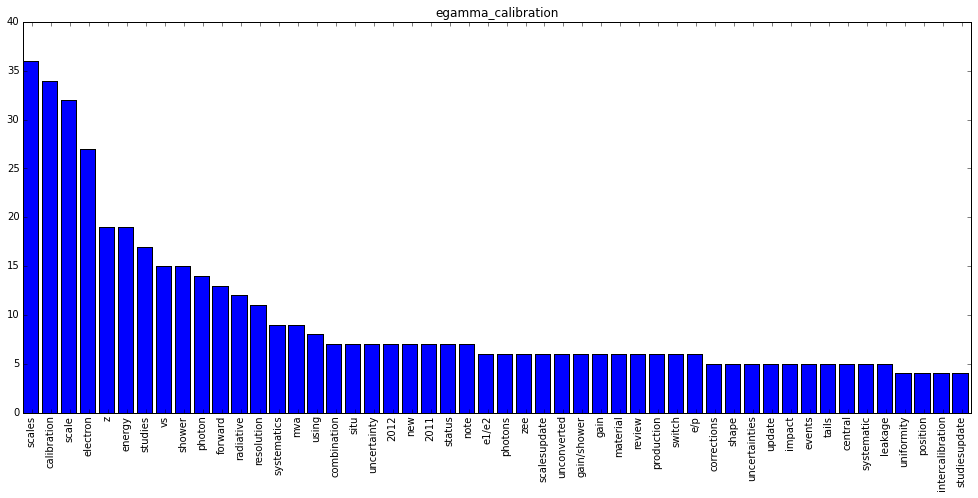

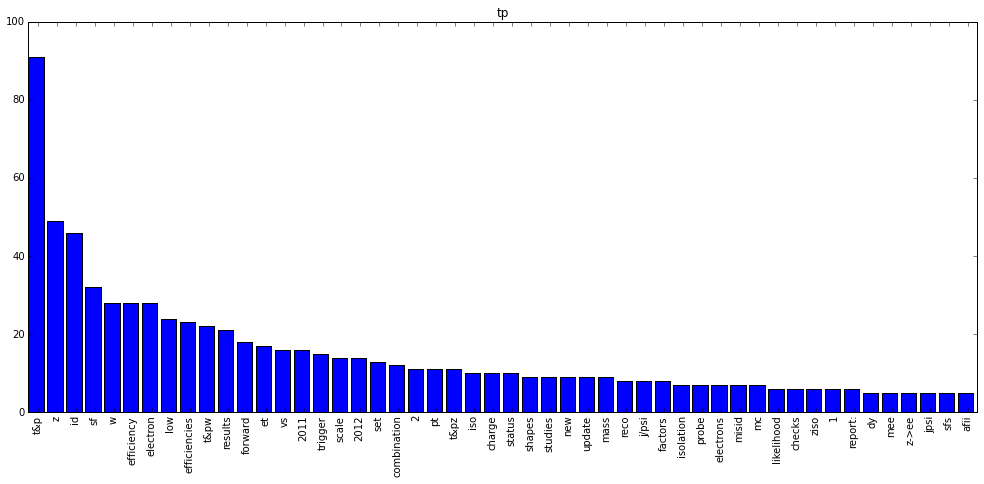

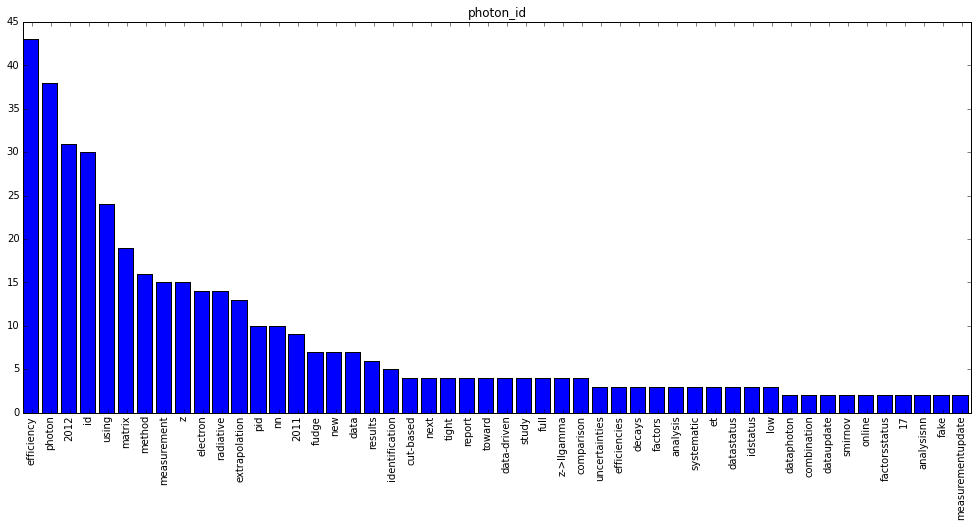

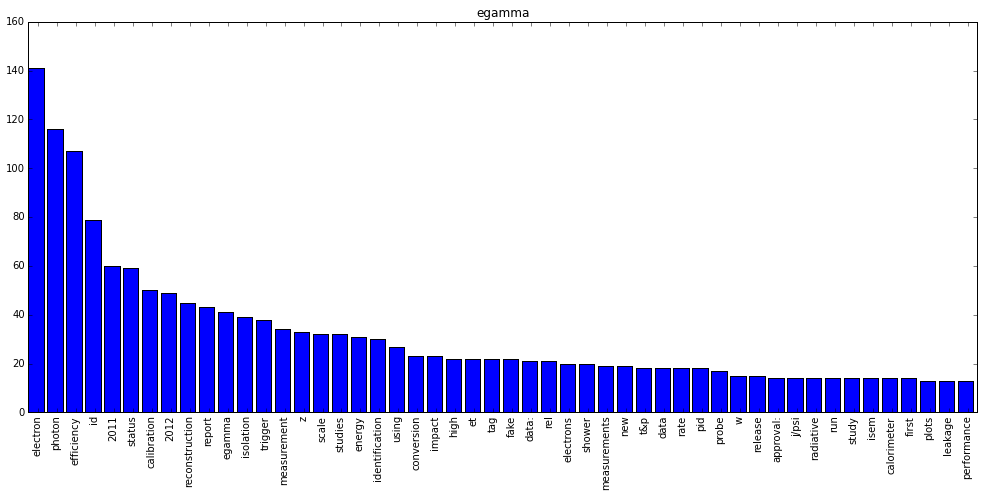

In [379]:
from collections import Counter
common_words = 'on -> with for - in ; : & the of and from at a to from by an'.split()


for k, v in df.groupby('my_title')['title_contribution'].sum().str.lower().str.split().to_dict().iteritems():
    words = filter(lambda x: x not in common_words, v)
    words = [w.strip(',.;-_') for w in words]

    histo_words = Counter(words)
    values = np.array(histo_words.values())
    labels = np.array(histo_words.keys())
    idx = np.argsort(values)[::-1]
    
    fig, ax = plt.subplots(figsize=(17, 7))
    ax.bar(np.arange(50), values[idx][:50])
    ax.set_xticklabels(labels[idx][:100], rotation=90)
    ax.set_xticks(np.arange(50) + 0.5)
    ax.set_title(k)
plt.show()

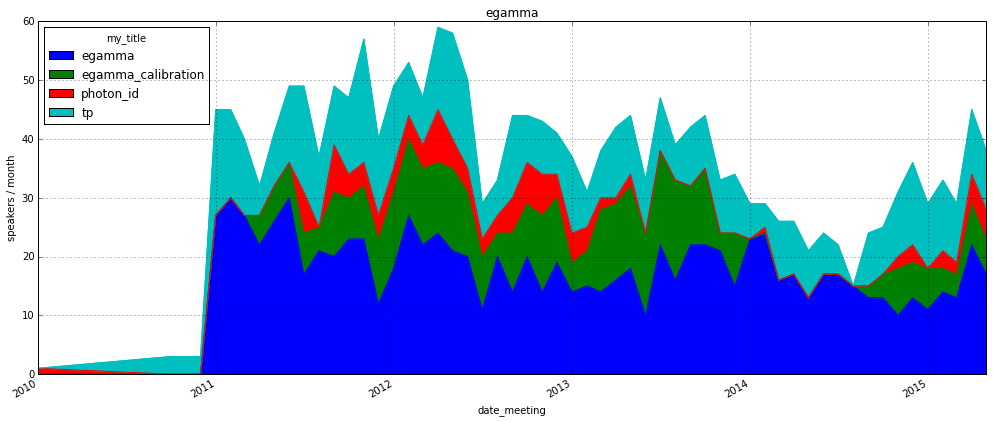

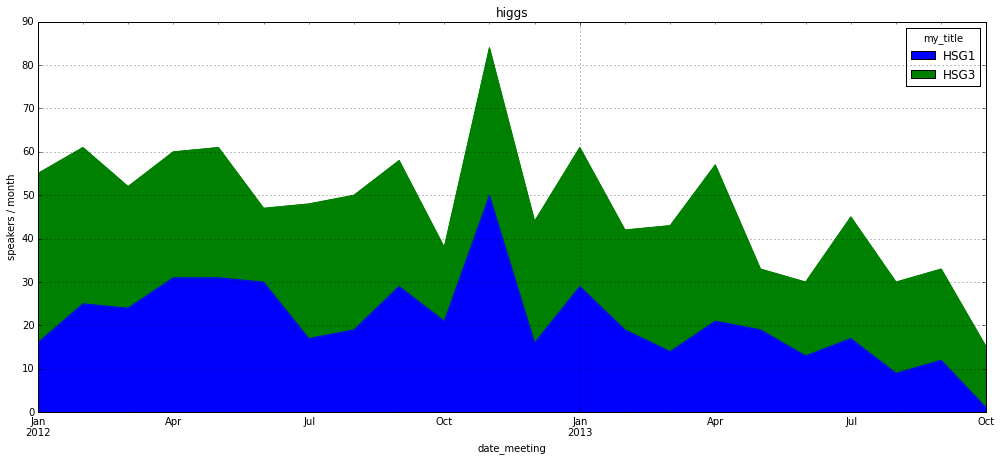

In [118]:
for group, group_data in df_grouped_by_group:
    fig, ax = plt.subplots(figsize=(17, 7))
    group_data.groupby([pd.Grouper(freq='1MS',key='date_meeting'), 'my_title'])['speaker'].unique().apply(lambda x: len(x)).unstack().plot(ax=ax, kind='area')
    ax.set_ylabel('speakers / month')
    ax.set_title(group)

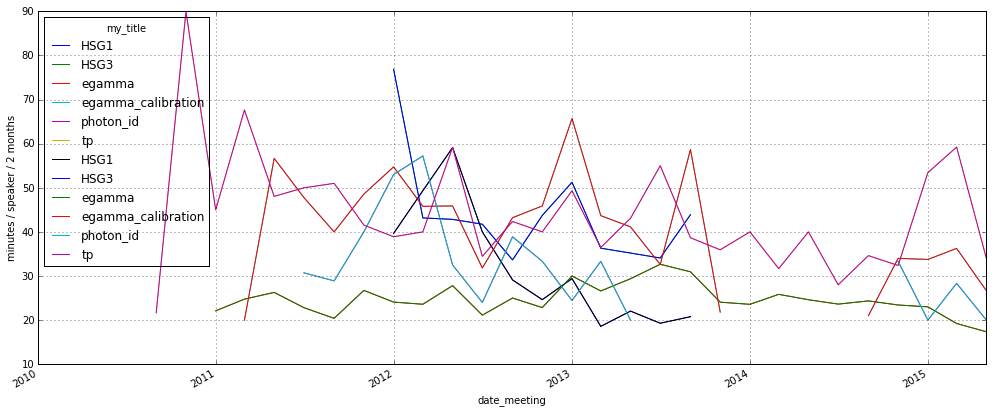

In [385]:
fig, ax = plt.subplots(figsize=(17, 7))
((df.groupby([pd.Grouper(freq='2MS',key='date_meeting'), 'my_title'])['duration'].sum().unstack().fillna(0)) / df.groupby([pd.Grouper(freq='2MS',key='date_meeting'), 'my_title'])['speaker'].unique().apply(lambda x: len(x)).unstack()).plot(ax=ax)
((df.groupby([pd.Grouper(freq='2MS',key='date_meeting'), 'my_title'])['duration'].sum().unstack().fillna(0)) / df.groupby([pd.Grouper(freq='2MS',key='date_meeting'), 'my_title'])['speaker'].unique().apply(lambda x: len(x)).unstack()).plot(ax=ax)
ax.set_ylabel('minutes / speaker / 2 months')